# MOS score prediction from wav2vec2 embeddings

* calculate wav2vec2 embeddings for test and train datasets
* create MOSDataset, containing wav2vec2 embeddings and subjective MOS scores
* define a simple neural network to predict MOS scores from wav2vec2 embeddings
* train the neural network and save the model
* evaluate the model
* repeat the process for different wav2vec2 models? other embeddings? use embeddings from different layers? need another 8 months to finish this notebook

In [54]:
import os
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# wav2vec
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model, Wav2Vec2Config
import librosa

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# wav2vec2 embeddings extraction

In [2]:
def wav2vec_embeddings(path_to_csv, model_name, output_dir):
    """Extracts embeddings from audio files given a specific Wav2Vec2 model.
    Extracts all layers and stacks them together into a tensor. Then saves that tensor as a numpy array.
    Expects csv file with a column named "stimuli" containing paths to audio files."""

    os.makedirs(output_dir, exist_ok=True)

    config = Wav2Vec2Config.from_pretrained(model_name, output_hidden_states=True)
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
    model = Wav2Vec2Model(config)
    
    #load data
    metadata_df = pd.read_csv(path_to_csv)

    # iterate over each path in "stimuli" column
    for _, row in tqdm(metadata_df.iterrows()):
        audio_file = row['stimuli']
        input_audio, sample_rate = librosa.load(audio_file, sr=16000)
        inputs = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
        
        with torch.no_grad():
            outputs= model(**inputs)
        
        all_layer_embeddings = outputs.hidden_states

        # Concatenate hidden states from all layers and take the mean across the sequence
        # Skip the first layer --> output of the CNN layers with an added positional embedding
        embeddings = torch.cat(all_layer_embeddings[, dim=0)
        embeddings = embeddings.mean(dim=1)

        # Save embeddings as numpy array
        embeddings = embeddings.squeeze().detach().numpy()
        file_name = os.path.basename(audio_file).split('.')[0]

        np.save(os.path.join(output_dir, f"{file_name}.npy"), embeddings)

In [9]:
# extract embeddings for dev set
path_to_dev_csv = '/home/aleph/tesis/classifier/dev.csv'
path_to_dev_embeddings = '/home/aleph/tesis/classifier/embeddings/dev'
# wav2vec_embeddings(path_to_dev_csv, path_to_dev_embeddings)

# extract embeddings for test set
path_to_test_csv = '/home/aleph/tesis/classifier/test.csv'
path_to_test_embeddings = '/home/aleph/tesis/classifier/embeddings/test'
# wav2vec_embeddings(path_to_test_csv, path_to_test_embeddings)

# extract embeddings for train set
path_to_train_csv = '/home/aleph/tesis/classifier/train.csv'
path_to_train_embeddings = '/home/aleph/tesis/classifier/embeddings/train'
# wav2vec_embeddings(path_to_train_csv, path_to_train_embeddings)

OSError: facebook/wav2vec2-base-960h does not appear to have a file named config.json. Checkout 'https://huggingface.co/facebook/wav2vec2-base-960h/tree/main' for available files.

## attempt to plot some sort of distribution of the embeddings

In [12]:
# let's explore the embeddings to see distributions of data
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
from numpy import float32

# get the embeddings read from the csv
train_embeddings = pd.read_csv(path_to_save_train_embeddings)
test_embeddings = pd.read_csv(path_to_save_test_embeddings)

# get the embeddings
train_embeddings = train_embeddings['embeddings']
test_embeddings = test_embeddings['embeddings']

# convert the strings to lists
train_embeddings = train_embeddings.apply(lambda x: eval(x))
test_embeddings = test_embeddings.apply(lambda x: eval(x))

# convert the lists to numpy arrays
train_embeddings = np.array(train_embeddings.tolist())
test_embeddings = np.array(test_embeddings.tolist())

# get the shape of the embeddings
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")




Train embeddings shape: (3473, 1, 768)
Test embeddings shape: (863, 1, 768)


In [38]:
import umap.umap_ as umap

#Create a numpy array with the features and project them to 2D using UMAP:
X = np.stack(train_embeddings.squeeze())
print('Projecting to 2D with UMAP')
projector = umap.UMAP()
projected = projector.fit_transform(X)
metadata_df = pd.DataFrame()
metadata_df['X'] = projected[:,0]
metadata_df['Y'] = projected[:,1]

Projecting to 2D with UMAP


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


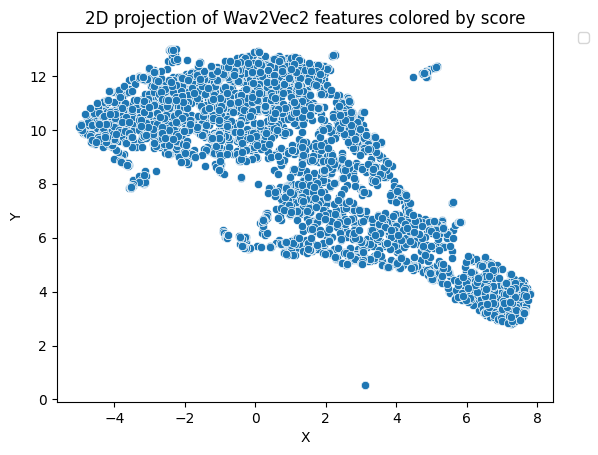

In [40]:
plt.title('2D projection of Wav2Vec2 features colored by score')
sns.scatterplot(data=metadata_df,x='X',y='Y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Projecting to 2D with UMAP


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


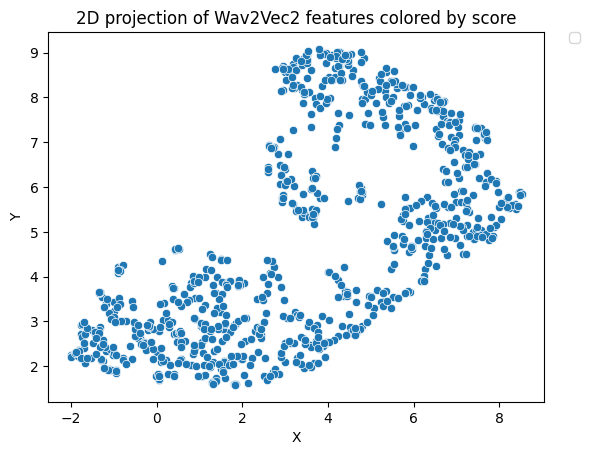

In [41]:
import umap.umap_ as umap

#Create a numpy array with the features and project them to 2D using UMAP:
X = np.stack(test_embeddings.squeeze())
print('Projecting to 2D with UMAP')
projector = umap.UMAP()
projected = projector.fit_transform(X)
metadata_df = pd.DataFrame()
metadata_df['X'] = projected[:,0]
metadata_df['Y'] = projected[:,1]

plt.title('2D projection of Wav2Vec2 features colored by score')
sns.scatterplot(data=metadata_df,x='X',y='Y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# MOSDataset
* Convert the embeddings from string representations into proper tensors.
* Separate the data into features (embeddings) and targets (MOS scores).

In [75]:
# Custom dataset to read embeddings and MOS scores from a CSV
from numpy import array
from numpy import float32

class MOSDataset(Dataset):
    def __init__(self, csv_file, split):
        # Load the CSV file
        self.data = pd.read_csv(csv_file)
        self.split = "shuffled"  # Store the split (train, val, test)

        
    def __len__(self):
        return len(self.data)  # Total number of samples in the dataset
    
    def __getitem__(self, idx):
        # Get the embeddings and MOS scores for the given index
        file_name = os.path.basename(self.data.iloc[idx]['stimuli'])
        file_folder = os.path.basename(os.path.dirname(self.data.iloc[idx]['stimuli']))

        embeddings_path = f"/home/aleph/tesis/classifier/embeddings/{self.split}/{file_folder}/{file_name.split('.')[0]}.npy"

        # Check if the embeddings file exists
        if not os.path.isfile(embeddings_path):
            raise FileNotFoundError(f"Embeddings file not found at {embeddings_path}")

        embeddings = np.load(embeddings_path)

        mos_score = self.data.iloc[idx]['mos']

        # Convert the numpy array of embeddings to a tensor
        embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)  # Convert to PyTorch tensor

        # drop first layer
        # embeddings_tensor = embeddings_tensor[1:]
                
        # MOS score should be a single value
        mos_tensor = torch.tensor([mos_score], dtype=torch.float32)  # Convert to tensor
        
        return embeddings_tensor, mos_tensor

# Create the training DataLoader
train_csv_path = "/home/aleph/tesis/classifier/train_shuffled.csv"
train_dataset = MOSDataset(train_csv_path, split='train')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)  # DataLoader with batching and shuffling

# Create the validation DataLoader
val_csv_path = "/home/aleph/tesis/classifier/val_shuffled.csv"
val_dataset = MOSDataset(val_csv_path, split='val')
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Create the testing DataLoader
test_csv_path = "/home/aleph/tesis/classifier/test_shuffled.csv"
test_dataset = MOSDataset(test_csv_path, split='test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2) 


In [76]:
# Test getting an item
try:
    embeddings, mos = val_dataset[300]  # Test the first item
    print("Embeddings shape:", embeddings.shape)  # Expected shape
    print("MOS score:", mos.item())  # Expected MOS score
except Exception as e:
    print("Error getting item:", e)

Embeddings shape: torch.Size([13, 768])
MOS score: 2.5


In [77]:
#print length of the datasets
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

Train dataset length: 3139
Validation dataset length: 393
Test dataset length: 392


# Neural network

In [78]:
class WeightedAverage(torch.nn.Module):
    def __init__(self, num_layers=12):
        super().__init__()
        self.weights = torch.nn.Parameter(data=torch.ones((num_layers,)))
       
    def forward(self, x):
        w = torch.nn.functional.softmax(self.weights, dim=0)
        x_weighted = x*w[None,:,None]
        return torch.sum(x_weighted, dim=1)

class DenseMOS(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob, num_layers):
        super(DenseMOS, self).__init__()

        # add a weighted average layer
        self.weighted_average = WeightedAverage(num_layers)
        
        # First dense layer with 128 neurons, ReLU activation, and dropout
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Linear layer for dense transformation
            nn.ReLU(),  # ReLU activation
            nn.Dropout(dropout_prob),  # Dropout with 0.2
        )

        # Second dense layer, same design
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
        )

        # Final dense layer for MOS score prediction
        self.output_layer = nn.Linear(hidden_dim, 1)  # Linear layer to predict MOS

    def forward(self, x):
        # Apply the weighted average to combine 12 layers into 1
        x = self.weighted_average(x)  # Apply WeightedAverage

        # Pass the input through the first dense layer
        x = self.layer1(x)

        # Pass through the second dense layer
        x = self.layer2(x)

        # Pass through the final dense layer to get the MOS score
        x = self.output_layer(x)  # Output layer
        
        # min max normalization to 1-5
        x = 1 + (x - x.min()) * 4 / (x.max() - x.min())
        

        return x


# Define the model parameters
input_dim = 768  # Single 768-dimensional input
hidden_dim = 128  # Hidden dimension for dense layers
dropout_prob = 0.6  # Dropout probability
num_layers = 13  # Number of layers in the Wav2Vec2 model

# Training

In [79]:
# Instantiate the DenseMOS model
dense_mos = DenseMOS(input_dim, hidden_dim, dropout_prob, num_layers)
dense_mos.to(device)  # Move the model to the device

DenseMOS(
  (weighted_average): WeightedAverage()
  (layer1): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

## Define a Loss Function and Optimizer


In [80]:
# define loss and optimizer
loss_fn = nn.MSELoss()  # Mean squared error loss
# propose a different possible loss function
# loss_fn = nn.SmoothL1Loss()  # Huber loss

# Assuming you are using an optimizer like Adam
# optimizer = torch.optim.Adam(dense_mos.parameters(), lr=1e-4, weight_decay=1e-5)  # Add L2 regularization
# optimizer = torch.optim.Adam(dense_mos.parameters(), lr=1e-4)

base_params = [p for name, p in dense_mos.named_parameters() if "weights" not in name]
weight_params = [dense_mos.weighted_average.weights]
optimizer = torch.optim.Adam([
    {'params': base_params},
    {'params': weight_params, 'lr': 1e-3}  # Higher learning rate for weights
], lr=1e-4)

## Training Loop

In [81]:
# Number of epochs and batch size
num_epochs = 1000 # Number of training epochs
batch_size = 32  # Batch size for training

# DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Ensure batch size and shuffle
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No shuffle for validation

# Track training and validation loss
train_losses = []
val_losses = []

# For early stopping
best_val_loss = float('inf')  # To track the best validation loss
patience = 40  # Patience for early stopping
no_improvement_count = 0  # Counter for epochs without improvement

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Decay LR every 10 epochs

for epoch in range(num_epochs):
    # Training phase with progress bar
    dense_mos.train()  # Set model to training mode
    train_loss = 0.0  # Initialize the training loss
    
    # Use tqdm for progress tracking
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for inputs, targets in train_loader:
            inputs = inputs.to(device)  # Move inputs to the GPU
            targets = targets.to(device)  # Move targets to the GPU

            optimizer.zero_grad()  # Zero out the gradients
            
            outputs = dense_mos(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)  # Compute the loss
            loss.backward()  # Backpropagation
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(dense_mos.parameters(), 1.0)  # Adjust value if needed
            
            optimizer.step()  # Update the weights
            
            train_loss += loss.item()  # Accumulate the loss
            
            pbar.update(1)  # Update the progress bar

    train_loss /= len(train_loader)  # Average loss over all batches
    train_losses.append(train_loss)  # Save the training loss

    # Validation phase
    dense_mos.eval()  # Set model to evaluation mode
    val_loss = 0.0  # Initialize the validation loss

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)  # Move inputs to the GPU
            targets = targets.to(device)  # Move targets to the GPU

            outputs = dense_mos(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)  # Calculate loss
            val_loss += loss.item()  # Accumulate the validation loss

    val_loss /= len(val_loader)  # Average validation loss over all batches
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    # scheduler.step() # Step the scheduler

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(dense_mos.state_dict(), "best_model.pth")  # Save the best model
        no_improvement_count = 0  # Reset counter
    else:
        no_improvement_count += 1  # Increment counter if no improvement

    # Early stopping check
    if no_improvement_count >= patience:
        print(f"Stopping early after {epoch + 1} epochs due to no improvement in validation loss.")
        break

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the model (optional)
        torch.save(dense_mos.state_dict(), "best_model.pth")

    # Save the model at the end of training
    torch.save(dense_mos.state_dict(), "final_model.pth")

    # print the softmax of the weights of the weighted average layer
    # print(dense_mos.weighted_average.weights)
    # print(torch.nn.functional.softmax(dense_mos.weighted_average.weights, dim=0))
# save train and val losses to csv
losses = pd.DataFrame({'train_loss': train_losses, 'val_loss': val_losses})
losses.to_csv('losses.csv', index=False)

Epoch 1/1000: 100%|██████████| 99/99 [00:01<00:00, 75.86it/s]


Epoch 1/1000, Training Loss: 2.5505, Validation Loss: 2.0780


Epoch 2/1000: 100%|██████████| 99/99 [00:01<00:00, 72.42it/s]


Epoch 2/1000, Training Loss: 2.3696, Validation Loss: 1.9018


Epoch 3/1000: 100%|██████████| 99/99 [00:01<00:00, 81.27it/s]


Epoch 3/1000, Training Loss: 2.1808, Validation Loss: 1.9685


Epoch 4/1000: 100%|██████████| 99/99 [00:01<00:00, 80.73it/s]


Epoch 4/1000, Training Loss: 1.9723, Validation Loss: 1.9708


Epoch 5/1000: 100%|██████████| 99/99 [00:01<00:00, 85.92it/s]


Epoch 5/1000, Training Loss: 1.8398, Validation Loss: 1.8363


Epoch 6/1000: 100%|██████████| 99/99 [00:01<00:00, 84.86it/s]


Epoch 6/1000, Training Loss: 1.8077, Validation Loss: 1.7537


Epoch 7/1000: 100%|██████████| 99/99 [00:01<00:00, 86.78it/s]


Epoch 7/1000, Training Loss: 1.8838, Validation Loss: 1.5743


Epoch 8/1000: 100%|██████████| 99/99 [00:01<00:00, 88.23it/s]


Epoch 8/1000, Training Loss: 1.7245, Validation Loss: 1.5799


Epoch 9/1000: 100%|██████████| 99/99 [00:01<00:00, 78.70it/s]


Epoch 9/1000, Training Loss: 1.7069, Validation Loss: 1.4987


Epoch 10/1000: 100%|██████████| 99/99 [00:01<00:00, 73.90it/s]


Epoch 10/1000, Training Loss: 1.6107, Validation Loss: 1.4400


Epoch 11/1000: 100%|██████████| 99/99 [00:01<00:00, 74.76it/s]


Epoch 11/1000, Training Loss: 1.6655, Validation Loss: 1.4340


Epoch 12/1000: 100%|██████████| 99/99 [00:01<00:00, 83.18it/s]


Epoch 12/1000, Training Loss: 1.6503, Validation Loss: 1.4529


Epoch 13/1000: 100%|██████████| 99/99 [00:01<00:00, 80.28it/s]


Epoch 13/1000, Training Loss: 1.5969, Validation Loss: 1.4494


Epoch 14/1000: 100%|██████████| 99/99 [00:01<00:00, 75.58it/s]


Epoch 14/1000, Training Loss: 1.5608, Validation Loss: 1.4798


Epoch 15/1000: 100%|██████████| 99/99 [00:01<00:00, 80.34it/s]


Epoch 15/1000, Training Loss: 1.5451, Validation Loss: 1.4189


Epoch 16/1000: 100%|██████████| 99/99 [00:01<00:00, 80.69it/s]


Epoch 16/1000, Training Loss: 1.4404, Validation Loss: 1.4603


Epoch 17/1000: 100%|██████████| 99/99 [00:01<00:00, 75.08it/s]


Epoch 17/1000, Training Loss: 1.4971, Validation Loss: 1.3935


Epoch 18/1000: 100%|██████████| 99/99 [00:01<00:00, 83.02it/s]


Epoch 18/1000, Training Loss: 1.4394, Validation Loss: 1.2765


Epoch 19/1000: 100%|██████████| 99/99 [00:01<00:00, 80.84it/s]


Epoch 19/1000, Training Loss: 1.4532, Validation Loss: 1.3008


Epoch 20/1000: 100%|██████████| 99/99 [00:01<00:00, 86.99it/s]


Epoch 20/1000, Training Loss: 1.4566, Validation Loss: 1.4604


Epoch 21/1000: 100%|██████████| 99/99 [00:01<00:00, 91.10it/s]


Epoch 21/1000, Training Loss: 1.4325, Validation Loss: 1.3517


Epoch 22/1000: 100%|██████████| 99/99 [00:01<00:00, 92.22it/s]


Epoch 22/1000, Training Loss: 1.5126, Validation Loss: 1.3238


Epoch 23/1000: 100%|██████████| 99/99 [00:01<00:00, 84.84it/s]


Epoch 23/1000, Training Loss: 1.4459, Validation Loss: 1.3761


Epoch 24/1000: 100%|██████████| 99/99 [00:01<00:00, 84.04it/s]


Epoch 24/1000, Training Loss: 1.3813, Validation Loss: 1.4057


Epoch 25/1000: 100%|██████████| 99/99 [00:01<00:00, 89.85it/s]


Epoch 25/1000, Training Loss: 1.4096, Validation Loss: 1.5161


Epoch 26/1000: 100%|██████████| 99/99 [00:01<00:00, 80.30it/s]


Epoch 26/1000, Training Loss: 1.4062, Validation Loss: 1.3974


Epoch 27/1000: 100%|██████████| 99/99 [00:01<00:00, 91.64it/s]


Epoch 27/1000, Training Loss: 1.4033, Validation Loss: 1.4594


Epoch 28/1000: 100%|██████████| 99/99 [00:01<00:00, 91.62it/s]


Epoch 28/1000, Training Loss: 1.3933, Validation Loss: 1.2270


Epoch 29/1000: 100%|██████████| 99/99 [00:01<00:00, 92.88it/s]


Epoch 29/1000, Training Loss: 1.3906, Validation Loss: 1.3475


Epoch 30/1000: 100%|██████████| 99/99 [00:01<00:00, 94.99it/s]


Epoch 30/1000, Training Loss: 1.3752, Validation Loss: 1.3847


Epoch 31/1000: 100%|██████████| 99/99 [00:01<00:00, 96.16it/s]


Epoch 31/1000, Training Loss: 1.4146, Validation Loss: 1.3932


Epoch 32/1000: 100%|██████████| 99/99 [00:01<00:00, 96.66it/s]


Epoch 32/1000, Training Loss: 1.3679, Validation Loss: 1.3022


Epoch 33/1000: 100%|██████████| 99/99 [00:01<00:00, 95.22it/s]


Epoch 33/1000, Training Loss: 1.3305, Validation Loss: 1.4732


Epoch 34/1000: 100%|██████████| 99/99 [00:01<00:00, 87.22it/s]


Epoch 34/1000, Training Loss: 1.3507, Validation Loss: 1.3326


Epoch 35/1000: 100%|██████████| 99/99 [00:01<00:00, 85.93it/s]


Epoch 35/1000, Training Loss: 1.3435, Validation Loss: 1.3240


Epoch 36/1000: 100%|██████████| 99/99 [00:01<00:00, 92.64it/s]


Epoch 36/1000, Training Loss: 1.3379, Validation Loss: 1.3778


Epoch 37/1000: 100%|██████████| 99/99 [00:01<00:00, 96.87it/s]


Epoch 37/1000, Training Loss: 1.3725, Validation Loss: 1.2544


Epoch 38/1000: 100%|██████████| 99/99 [00:00<00:00, 99.71it/s] 


Epoch 38/1000, Training Loss: 1.3300, Validation Loss: 1.2788


Epoch 39/1000: 100%|██████████| 99/99 [00:01<00:00, 85.98it/s]


Epoch 39/1000, Training Loss: 1.3745, Validation Loss: 1.2934


Epoch 40/1000: 100%|██████████| 99/99 [00:01<00:00, 93.01it/s]


Epoch 40/1000, Training Loss: 1.2948, Validation Loss: 1.3455


Epoch 41/1000: 100%|██████████| 99/99 [00:01<00:00, 93.56it/s]


Epoch 41/1000, Training Loss: 1.2805, Validation Loss: 1.3109


Epoch 42/1000: 100%|██████████| 99/99 [00:01<00:00, 92.40it/s]


Epoch 42/1000, Training Loss: 1.2775, Validation Loss: 1.2496


Epoch 43/1000: 100%|██████████| 99/99 [00:01<00:00, 82.28it/s]


Epoch 43/1000, Training Loss: 1.3589, Validation Loss: 1.2999


Epoch 44/1000: 100%|██████████| 99/99 [00:01<00:00, 94.34it/s]


Epoch 44/1000, Training Loss: 1.3881, Validation Loss: 1.3811


Epoch 45/1000: 100%|██████████| 99/99 [00:01<00:00, 83.46it/s]


Epoch 45/1000, Training Loss: 1.3361, Validation Loss: 1.3305


Epoch 46/1000: 100%|██████████| 99/99 [00:01<00:00, 80.49it/s]


Epoch 46/1000, Training Loss: 1.3138, Validation Loss: 1.3347


Epoch 47/1000: 100%|██████████| 99/99 [00:01<00:00, 87.76it/s]


Epoch 47/1000, Training Loss: 1.2607, Validation Loss: 1.3093


Epoch 48/1000: 100%|██████████| 99/99 [00:01<00:00, 86.12it/s]


Epoch 48/1000, Training Loss: 1.2709, Validation Loss: 1.3192


Epoch 49/1000: 100%|██████████| 99/99 [00:01<00:00, 93.09it/s]


Epoch 49/1000, Training Loss: 1.1890, Validation Loss: 1.2842


Epoch 50/1000: 100%|██████████| 99/99 [00:01<00:00, 90.85it/s]


Epoch 50/1000, Training Loss: 1.2166, Validation Loss: 1.2194


Epoch 51/1000: 100%|██████████| 99/99 [00:01<00:00, 93.18it/s]


Epoch 51/1000, Training Loss: 1.2774, Validation Loss: 1.2470


Epoch 52/1000: 100%|██████████| 99/99 [00:01<00:00, 89.22it/s]


Epoch 52/1000, Training Loss: 1.2025, Validation Loss: 1.2593


Epoch 53/1000: 100%|██████████| 99/99 [00:01<00:00, 89.27it/s]


Epoch 53/1000, Training Loss: 1.2755, Validation Loss: 1.3365


Epoch 54/1000: 100%|██████████| 99/99 [00:01<00:00, 93.74it/s]


Epoch 54/1000, Training Loss: 1.1880, Validation Loss: 1.2543


Epoch 55/1000: 100%|██████████| 99/99 [00:01<00:00, 91.61it/s]


Epoch 55/1000, Training Loss: 1.2143, Validation Loss: 1.2618


Epoch 56/1000: 100%|██████████| 99/99 [00:01<00:00, 89.71it/s]


Epoch 56/1000, Training Loss: 1.2372, Validation Loss: 1.3202


Epoch 57/1000: 100%|██████████| 99/99 [00:01<00:00, 93.15it/s]


Epoch 57/1000, Training Loss: 1.2142, Validation Loss: 1.2884


Epoch 58/1000: 100%|██████████| 99/99 [00:01<00:00, 91.29it/s]


Epoch 58/1000, Training Loss: 1.2109, Validation Loss: 1.2092


Epoch 59/1000: 100%|██████████| 99/99 [00:01<00:00, 91.00it/s]


Epoch 59/1000, Training Loss: 1.2577, Validation Loss: 1.2369


Epoch 60/1000: 100%|██████████| 99/99 [00:01<00:00, 84.23it/s]


Epoch 60/1000, Training Loss: 1.2561, Validation Loss: 1.2370


Epoch 61/1000: 100%|██████████| 99/99 [00:01<00:00, 91.66it/s]


Epoch 61/1000, Training Loss: 1.2271, Validation Loss: 1.2731


Epoch 62/1000: 100%|██████████| 99/99 [00:01<00:00, 91.14it/s]


Epoch 62/1000, Training Loss: 1.1643, Validation Loss: 1.2998


Epoch 63/1000: 100%|██████████| 99/99 [00:01<00:00, 93.98it/s]


Epoch 63/1000, Training Loss: 1.1866, Validation Loss: 1.1827


Epoch 64/1000: 100%|██████████| 99/99 [00:01<00:00, 85.38it/s]


Epoch 64/1000, Training Loss: 1.2054, Validation Loss: 1.2435


Epoch 65/1000: 100%|██████████| 99/99 [00:01<00:00, 88.87it/s]


Epoch 65/1000, Training Loss: 1.1548, Validation Loss: 1.2233


Epoch 66/1000: 100%|██████████| 99/99 [00:01<00:00, 91.00it/s]


Epoch 66/1000, Training Loss: 1.1648, Validation Loss: 1.2110


Epoch 67/1000: 100%|██████████| 99/99 [00:01<00:00, 92.57it/s]


Epoch 67/1000, Training Loss: 1.1467, Validation Loss: 1.2128


Epoch 68/1000: 100%|██████████| 99/99 [00:01<00:00, 92.17it/s]


Epoch 68/1000, Training Loss: 1.1853, Validation Loss: 1.2028


Epoch 69/1000: 100%|██████████| 99/99 [00:01<00:00, 92.14it/s]


Epoch 69/1000, Training Loss: 1.2065, Validation Loss: 1.2326


Epoch 70/1000: 100%|██████████| 99/99 [00:01<00:00, 94.07it/s]


Epoch 70/1000, Training Loss: 1.2152, Validation Loss: 1.2198


Epoch 71/1000: 100%|██████████| 99/99 [00:01<00:00, 90.79it/s]


Epoch 71/1000, Training Loss: 1.1467, Validation Loss: 1.2507


Epoch 72/1000: 100%|██████████| 99/99 [00:01<00:00, 87.16it/s]


Epoch 72/1000, Training Loss: 1.1385, Validation Loss: 1.2081


Epoch 73/1000: 100%|██████████| 99/99 [00:01<00:00, 79.43it/s]


Epoch 73/1000, Training Loss: 1.1261, Validation Loss: 1.1834


Epoch 74/1000: 100%|██████████| 99/99 [00:01<00:00, 78.46it/s]


Epoch 74/1000, Training Loss: 1.1236, Validation Loss: 1.2372


Epoch 75/1000: 100%|██████████| 99/99 [00:01<00:00, 81.01it/s]


Epoch 75/1000, Training Loss: 1.1231, Validation Loss: 1.2270


Epoch 76/1000: 100%|██████████| 99/99 [00:01<00:00, 85.68it/s]


Epoch 76/1000, Training Loss: 1.1359, Validation Loss: 1.1853


Epoch 77/1000: 100%|██████████| 99/99 [00:01<00:00, 82.70it/s]


Epoch 77/1000, Training Loss: 1.1659, Validation Loss: 1.1924


Epoch 78/1000: 100%|██████████| 99/99 [00:01<00:00, 83.80it/s]


Epoch 78/1000, Training Loss: 1.1424, Validation Loss: 1.2105


Epoch 79/1000: 100%|██████████| 99/99 [00:01<00:00, 91.24it/s]


Epoch 79/1000, Training Loss: 1.1452, Validation Loss: 1.2394


Epoch 80/1000: 100%|██████████| 99/99 [00:01<00:00, 93.45it/s]


Epoch 80/1000, Training Loss: 1.2008, Validation Loss: 1.2212


Epoch 81/1000: 100%|██████████| 99/99 [00:01<00:00, 83.92it/s]


Epoch 81/1000, Training Loss: 1.1043, Validation Loss: 1.1890


Epoch 82/1000: 100%|██████████| 99/99 [00:01<00:00, 79.08it/s]


Epoch 82/1000, Training Loss: 1.0979, Validation Loss: 1.1975


Epoch 83/1000: 100%|██████████| 99/99 [00:01<00:00, 75.09it/s]


Epoch 83/1000, Training Loss: 1.1229, Validation Loss: 1.2158


Epoch 84/1000: 100%|██████████| 99/99 [00:01<00:00, 85.65it/s]


Epoch 84/1000, Training Loss: 1.0853, Validation Loss: 1.1622


Epoch 85/1000: 100%|██████████| 99/99 [00:01<00:00, 91.05it/s]


Epoch 85/1000, Training Loss: 1.1395, Validation Loss: 1.2209


Epoch 86/1000: 100%|██████████| 99/99 [00:01<00:00, 89.55it/s]


Epoch 86/1000, Training Loss: 1.1735, Validation Loss: 1.2066


Epoch 87/1000: 100%|██████████| 99/99 [00:01<00:00, 85.83it/s]


Epoch 87/1000, Training Loss: 1.1128, Validation Loss: 1.2112


Epoch 88/1000: 100%|██████████| 99/99 [00:01<00:00, 87.73it/s]


Epoch 88/1000, Training Loss: 1.1203, Validation Loss: 1.2055


Epoch 89/1000: 100%|██████████| 99/99 [00:01<00:00, 86.13it/s]


Epoch 89/1000, Training Loss: 1.1285, Validation Loss: 1.1997


Epoch 90/1000: 100%|██████████| 99/99 [00:01<00:00, 87.70it/s]


Epoch 90/1000, Training Loss: 1.1853, Validation Loss: 1.1735


Epoch 91/1000: 100%|██████████| 99/99 [00:01<00:00, 84.68it/s]


Epoch 91/1000, Training Loss: 1.1351, Validation Loss: 1.1879


Epoch 92/1000: 100%|██████████| 99/99 [00:01<00:00, 85.50it/s]


Epoch 92/1000, Training Loss: 1.1672, Validation Loss: 1.1952


Epoch 93/1000: 100%|██████████| 99/99 [00:01<00:00, 92.49it/s]


Epoch 93/1000, Training Loss: 1.0800, Validation Loss: 1.2292


Epoch 94/1000: 100%|██████████| 99/99 [00:01<00:00, 97.16it/s]


Epoch 94/1000, Training Loss: 1.0797, Validation Loss: 1.1527


Epoch 95/1000: 100%|██████████| 99/99 [00:01<00:00, 87.97it/s]


Epoch 95/1000, Training Loss: 1.0999, Validation Loss: 1.1934


Epoch 96/1000: 100%|██████████| 99/99 [00:01<00:00, 91.25it/s]


Epoch 96/1000, Training Loss: 1.1456, Validation Loss: 1.1766


Epoch 97/1000: 100%|██████████| 99/99 [00:01<00:00, 91.99it/s]


Epoch 97/1000, Training Loss: 1.0883, Validation Loss: 1.1460


Epoch 98/1000: 100%|██████████| 99/99 [00:01<00:00, 91.22it/s]


Epoch 98/1000, Training Loss: 1.1097, Validation Loss: 1.2386


Epoch 99/1000: 100%|██████████| 99/99 [00:01<00:00, 92.31it/s]


Epoch 99/1000, Training Loss: 1.1063, Validation Loss: 1.1713


Epoch 100/1000: 100%|██████████| 99/99 [00:01<00:00, 88.35it/s]


Epoch 100/1000, Training Loss: 1.0915, Validation Loss: 1.3077


Epoch 101/1000: 100%|██████████| 99/99 [00:01<00:00, 87.82it/s]


Epoch 101/1000, Training Loss: 1.1083, Validation Loss: 1.2054


Epoch 102/1000: 100%|██████████| 99/99 [00:01<00:00, 91.33it/s]


Epoch 102/1000, Training Loss: 1.1050, Validation Loss: 1.1840


Epoch 103/1000: 100%|██████████| 99/99 [00:01<00:00, 83.56it/s]


Epoch 103/1000, Training Loss: 1.1302, Validation Loss: 1.1533


Epoch 104/1000: 100%|██████████| 99/99 [00:01<00:00, 86.98it/s]


Epoch 104/1000, Training Loss: 1.0663, Validation Loss: 1.1695


Epoch 105/1000: 100%|██████████| 99/99 [00:01<00:00, 92.39it/s]


Epoch 105/1000, Training Loss: 1.0461, Validation Loss: 1.1785


Epoch 106/1000: 100%|██████████| 99/99 [00:01<00:00, 93.19it/s]


Epoch 106/1000, Training Loss: 1.1304, Validation Loss: 1.1663


Epoch 107/1000: 100%|██████████| 99/99 [00:01<00:00, 86.72it/s]


Epoch 107/1000, Training Loss: 1.0074, Validation Loss: 1.1982


Epoch 108/1000: 100%|██████████| 99/99 [00:01<00:00, 78.64it/s]


Epoch 108/1000, Training Loss: 1.1118, Validation Loss: 1.1624


Epoch 109/1000: 100%|██████████| 99/99 [00:01<00:00, 81.29it/s]


Epoch 109/1000, Training Loss: 1.0363, Validation Loss: 1.2164


Epoch 110/1000: 100%|██████████| 99/99 [00:01<00:00, 78.07it/s]


Epoch 110/1000, Training Loss: 1.0603, Validation Loss: 1.2046


Epoch 111/1000: 100%|██████████| 99/99 [00:01<00:00, 88.85it/s]


Epoch 111/1000, Training Loss: 1.0573, Validation Loss: 1.1886


Epoch 112/1000: 100%|██████████| 99/99 [00:01<00:00, 88.63it/s]


Epoch 112/1000, Training Loss: 1.0634, Validation Loss: 1.1694


Epoch 113/1000: 100%|██████████| 99/99 [00:01<00:00, 88.73it/s]


Epoch 113/1000, Training Loss: 1.0517, Validation Loss: 1.1875


Epoch 114/1000: 100%|██████████| 99/99 [00:01<00:00, 89.76it/s]


Epoch 114/1000, Training Loss: 1.0290, Validation Loss: 1.1441


Epoch 115/1000: 100%|██████████| 99/99 [00:01<00:00, 87.80it/s]


Epoch 115/1000, Training Loss: 1.0062, Validation Loss: 1.1581


Epoch 116/1000: 100%|██████████| 99/99 [00:01<00:00, 88.04it/s]


Epoch 116/1000, Training Loss: 1.0784, Validation Loss: 1.1928


Epoch 117/1000: 100%|██████████| 99/99 [00:01<00:00, 82.80it/s]


Epoch 117/1000, Training Loss: 1.0171, Validation Loss: 1.1753


Epoch 118/1000: 100%|██████████| 99/99 [00:01<00:00, 81.22it/s]


Epoch 118/1000, Training Loss: 1.0102, Validation Loss: 1.1914


Epoch 119/1000: 100%|██████████| 99/99 [00:01<00:00, 79.37it/s]


Epoch 119/1000, Training Loss: 1.0706, Validation Loss: 1.1746


Epoch 120/1000: 100%|██████████| 99/99 [00:01<00:00, 89.08it/s]


Epoch 120/1000, Training Loss: 1.0715, Validation Loss: 1.2186


Epoch 121/1000: 100%|██████████| 99/99 [00:01<00:00, 92.23it/s]


Epoch 121/1000, Training Loss: 1.0166, Validation Loss: 1.1776


Epoch 122/1000: 100%|██████████| 99/99 [00:01<00:00, 93.45it/s]


Epoch 122/1000, Training Loss: 0.9864, Validation Loss: 1.1112


Epoch 123/1000: 100%|██████████| 99/99 [00:01<00:00, 89.68it/s]


Epoch 123/1000, Training Loss: 1.0264, Validation Loss: 1.1635


Epoch 124/1000: 100%|██████████| 99/99 [00:01<00:00, 90.23it/s]


Epoch 124/1000, Training Loss: 1.0327, Validation Loss: 1.1676


Epoch 125/1000: 100%|██████████| 99/99 [00:01<00:00, 90.01it/s]


Epoch 125/1000, Training Loss: 1.0468, Validation Loss: 1.1666


Epoch 126/1000: 100%|██████████| 99/99 [00:01<00:00, 89.36it/s]


Epoch 126/1000, Training Loss: 1.0099, Validation Loss: 1.1441


Epoch 127/1000: 100%|██████████| 99/99 [00:01<00:00, 88.02it/s]


Epoch 127/1000, Training Loss: 1.0648, Validation Loss: 1.1260


Epoch 128/1000: 100%|██████████| 99/99 [00:01<00:00, 88.53it/s]


Epoch 128/1000, Training Loss: 1.0392, Validation Loss: 1.1324


Epoch 129/1000: 100%|██████████| 99/99 [00:01<00:00, 89.86it/s]


Epoch 129/1000, Training Loss: 1.0365, Validation Loss: 1.1250


Epoch 130/1000: 100%|██████████| 99/99 [00:01<00:00, 86.54it/s]


Epoch 130/1000, Training Loss: 1.1317, Validation Loss: 1.2260


Epoch 131/1000: 100%|██████████| 99/99 [00:01<00:00, 89.26it/s]


Epoch 131/1000, Training Loss: 0.9887, Validation Loss: 1.2284


Epoch 132/1000: 100%|██████████| 99/99 [00:01<00:00, 82.73it/s]


Epoch 132/1000, Training Loss: 0.9998, Validation Loss: 1.1083


Epoch 133/1000: 100%|██████████| 99/99 [00:01<00:00, 81.70it/s]


Epoch 133/1000, Training Loss: 1.0342, Validation Loss: 1.1178


Epoch 134/1000: 100%|██████████| 99/99 [00:01<00:00, 90.10it/s]


Epoch 134/1000, Training Loss: 0.9828, Validation Loss: 1.1513


Epoch 135/1000: 100%|██████████| 99/99 [00:01<00:00, 84.85it/s]


Epoch 135/1000, Training Loss: 1.0166, Validation Loss: 1.1822


Epoch 136/1000: 100%|██████████| 99/99 [00:01<00:00, 84.59it/s]


Epoch 136/1000, Training Loss: 1.0274, Validation Loss: 1.0892


Epoch 137/1000: 100%|██████████| 99/99 [00:01<00:00, 88.55it/s]


Epoch 137/1000, Training Loss: 0.9659, Validation Loss: 1.1598


Epoch 138/1000: 100%|██████████| 99/99 [00:01<00:00, 86.49it/s]


Epoch 138/1000, Training Loss: 1.0177, Validation Loss: 1.2020


Epoch 139/1000: 100%|██████████| 99/99 [00:01<00:00, 79.12it/s]


Epoch 139/1000, Training Loss: 1.0420, Validation Loss: 1.1556


Epoch 140/1000: 100%|██████████| 99/99 [00:01<00:00, 80.01it/s]


Epoch 140/1000, Training Loss: 1.0122, Validation Loss: 1.1259


Epoch 141/1000: 100%|██████████| 99/99 [00:01<00:00, 77.53it/s]


Epoch 141/1000, Training Loss: 1.0153, Validation Loss: 1.1077


Epoch 142/1000: 100%|██████████| 99/99 [00:01<00:00, 75.99it/s]


Epoch 142/1000, Training Loss: 0.9837, Validation Loss: 1.1272


Epoch 143/1000: 100%|██████████| 99/99 [00:01<00:00, 89.79it/s]


Epoch 143/1000, Training Loss: 0.9932, Validation Loss: 1.1264


Epoch 144/1000: 100%|██████████| 99/99 [00:01<00:00, 96.03it/s]


Epoch 144/1000, Training Loss: 0.9693, Validation Loss: 1.1523


Epoch 145/1000: 100%|██████████| 99/99 [00:01<00:00, 96.25it/s]


Epoch 145/1000, Training Loss: 1.0323, Validation Loss: 1.1018


Epoch 146/1000: 100%|██████████| 99/99 [00:01<00:00, 84.67it/s]


Epoch 146/1000, Training Loss: 1.0154, Validation Loss: 1.1564


Epoch 147/1000: 100%|██████████| 99/99 [00:01<00:00, 87.62it/s]


Epoch 147/1000, Training Loss: 0.9399, Validation Loss: 1.1219


Epoch 148/1000: 100%|██████████| 99/99 [00:01<00:00, 96.13it/s]


Epoch 148/1000, Training Loss: 1.0062, Validation Loss: 1.1906


Epoch 149/1000: 100%|██████████| 99/99 [00:01<00:00, 91.67it/s] 


Epoch 149/1000, Training Loss: 1.0270, Validation Loss: 1.1127


Epoch 150/1000: 100%|██████████| 99/99 [00:01<00:00, 91.08it/s]


Epoch 150/1000, Training Loss: 0.9574, Validation Loss: 1.1307


Epoch 151/1000: 100%|██████████| 99/99 [00:01<00:00, 84.02it/s]


Epoch 151/1000, Training Loss: 0.9636, Validation Loss: 1.1728


Epoch 152/1000: 100%|██████████| 99/99 [00:01<00:00, 67.32it/s]


Epoch 152/1000, Training Loss: 0.9985, Validation Loss: 1.1359


Epoch 153/1000: 100%|██████████| 99/99 [00:01<00:00, 64.42it/s]


Epoch 153/1000, Training Loss: 0.9603, Validation Loss: 1.1733


Epoch 154/1000: 100%|██████████| 99/99 [00:01<00:00, 78.33it/s]


Epoch 154/1000, Training Loss: 0.9529, Validation Loss: 1.1183


Epoch 155/1000: 100%|██████████| 99/99 [00:01<00:00, 82.12it/s]


Epoch 155/1000, Training Loss: 1.0211, Validation Loss: 1.1598


Epoch 156/1000: 100%|██████████| 99/99 [00:01<00:00, 85.36it/s]


Epoch 156/1000, Training Loss: 0.9734, Validation Loss: 1.1715


Epoch 157/1000: 100%|██████████| 99/99 [00:01<00:00, 90.03it/s]


Epoch 157/1000, Training Loss: 0.9069, Validation Loss: 1.2255


Epoch 158/1000: 100%|██████████| 99/99 [00:01<00:00, 86.67it/s]


Epoch 158/1000, Training Loss: 0.9710, Validation Loss: 1.1208


Epoch 159/1000: 100%|██████████| 99/99 [00:01<00:00, 81.34it/s]


Epoch 159/1000, Training Loss: 0.9160, Validation Loss: 1.1607


Epoch 160/1000: 100%|██████████| 99/99 [00:01<00:00, 81.32it/s]


Epoch 160/1000, Training Loss: 0.8992, Validation Loss: 1.1257


Epoch 161/1000: 100%|██████████| 99/99 [00:01<00:00, 88.76it/s]


Epoch 161/1000, Training Loss: 0.9381, Validation Loss: 1.1373


Epoch 162/1000: 100%|██████████| 99/99 [00:01<00:00, 89.91it/s]


Epoch 162/1000, Training Loss: 0.9698, Validation Loss: 1.1060


Epoch 163/1000: 100%|██████████| 99/99 [00:01<00:00, 87.36it/s]


Epoch 163/1000, Training Loss: 0.9499, Validation Loss: 1.1260


Epoch 164/1000: 100%|██████████| 99/99 [00:01<00:00, 87.41it/s]


Epoch 164/1000, Training Loss: 0.9095, Validation Loss: 1.1117


Epoch 165/1000: 100%|██████████| 99/99 [00:01<00:00, 78.12it/s]


Epoch 165/1000, Training Loss: 0.9313, Validation Loss: 1.1479


Epoch 166/1000: 100%|██████████| 99/99 [00:01<00:00, 74.22it/s]


Epoch 166/1000, Training Loss: 0.9245, Validation Loss: 1.1513


Epoch 167/1000: 100%|██████████| 99/99 [00:01<00:00, 73.11it/s]


Epoch 167/1000, Training Loss: 0.9181, Validation Loss: 1.1495


Epoch 168/1000: 100%|██████████| 99/99 [00:01<00:00, 63.00it/s]


Epoch 168/1000, Training Loss: 0.9378, Validation Loss: 1.1661


Epoch 169/1000: 100%|██████████| 99/99 [00:01<00:00, 61.08it/s]


Epoch 169/1000, Training Loss: 0.9029, Validation Loss: 1.1400


Epoch 170/1000: 100%|██████████| 99/99 [00:01<00:00, 58.94it/s]


Epoch 170/1000, Training Loss: 0.9594, Validation Loss: 1.1453


Epoch 171/1000: 100%|██████████| 99/99 [00:01<00:00, 61.99it/s]


Epoch 171/1000, Training Loss: 0.9645, Validation Loss: 1.1463


Epoch 172/1000: 100%|██████████| 99/99 [00:01<00:00, 66.54it/s]


Epoch 172/1000, Training Loss: 0.8866, Validation Loss: 1.1522


Epoch 173/1000: 100%|██████████| 99/99 [00:01<00:00, 79.55it/s]


Epoch 173/1000, Training Loss: 0.8880, Validation Loss: 1.0985


Epoch 174/1000: 100%|██████████| 99/99 [00:01<00:00, 63.67it/s]


Epoch 174/1000, Training Loss: 0.9394, Validation Loss: 1.1604


Epoch 175/1000: 100%|██████████| 99/99 [00:01<00:00, 66.12it/s]


Epoch 175/1000, Training Loss: 0.9629, Validation Loss: 1.1348


Epoch 176/1000: 100%|██████████| 99/99 [00:01<00:00, 67.38it/s]


Epoch 176/1000, Training Loss: 0.8803, Validation Loss: 1.1385
Stopping early after 176 epochs due to no improvement in validation loss.


### plot

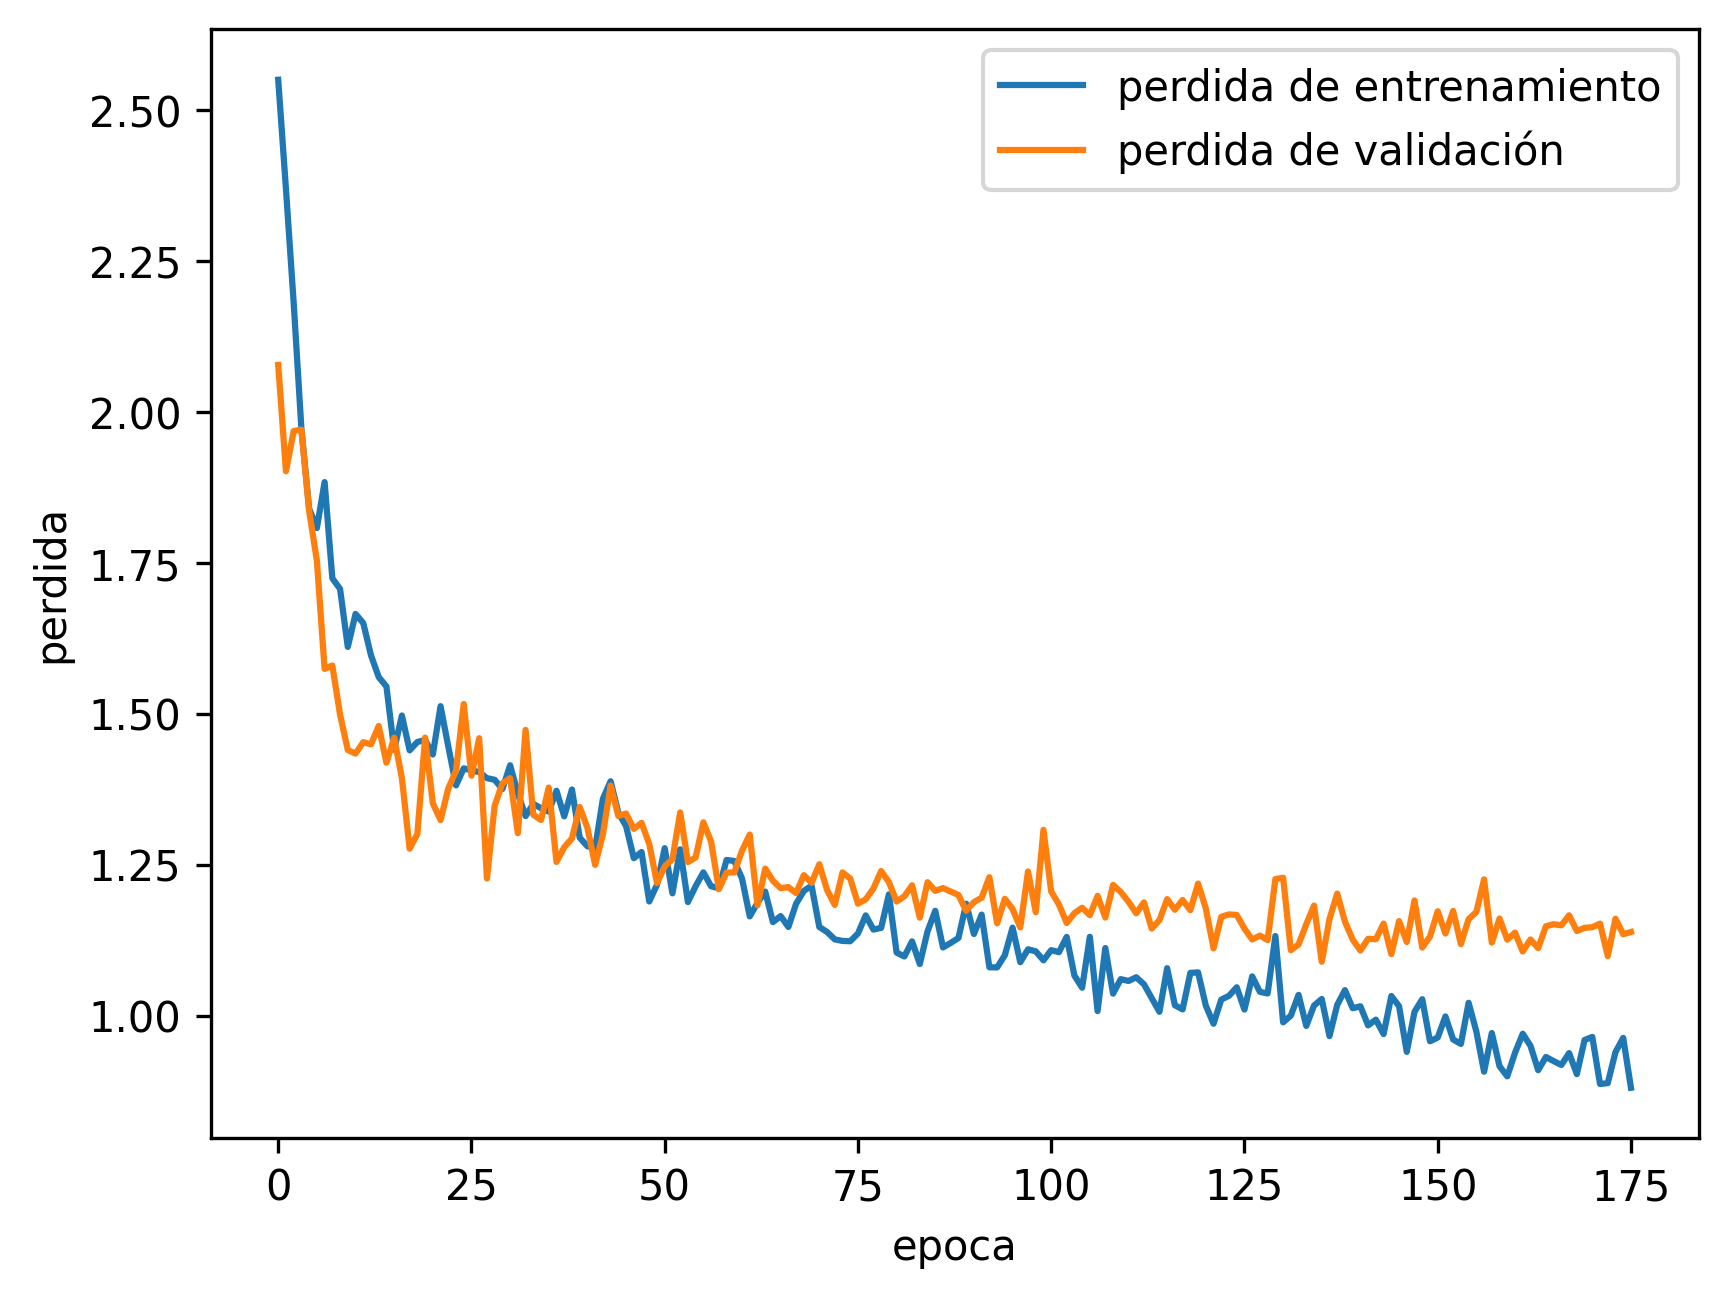

Best validation loss: 1.089238132421787
epoch for best validation loss: 135


In [83]:
# best quality for plots
plt.rcParams['figure.dpi'] = 300

losses = pd.read_csv('losses.csv')
train_losses = losses['train_loss']
val_losses = losses['val_loss']

plt.plot(train_losses, label='perdida de entrenamiento')
plt.plot(val_losses, label='perdida de validación')
# set x-axis label
plt.xlabel('epoca')
# set y-axis label
plt.ylabel('perdida')
plt.legend()
plt.show()

print("Best validation loss:", best_val_loss)
print("epoch for best validation loss:", np.argmin(val_losses))

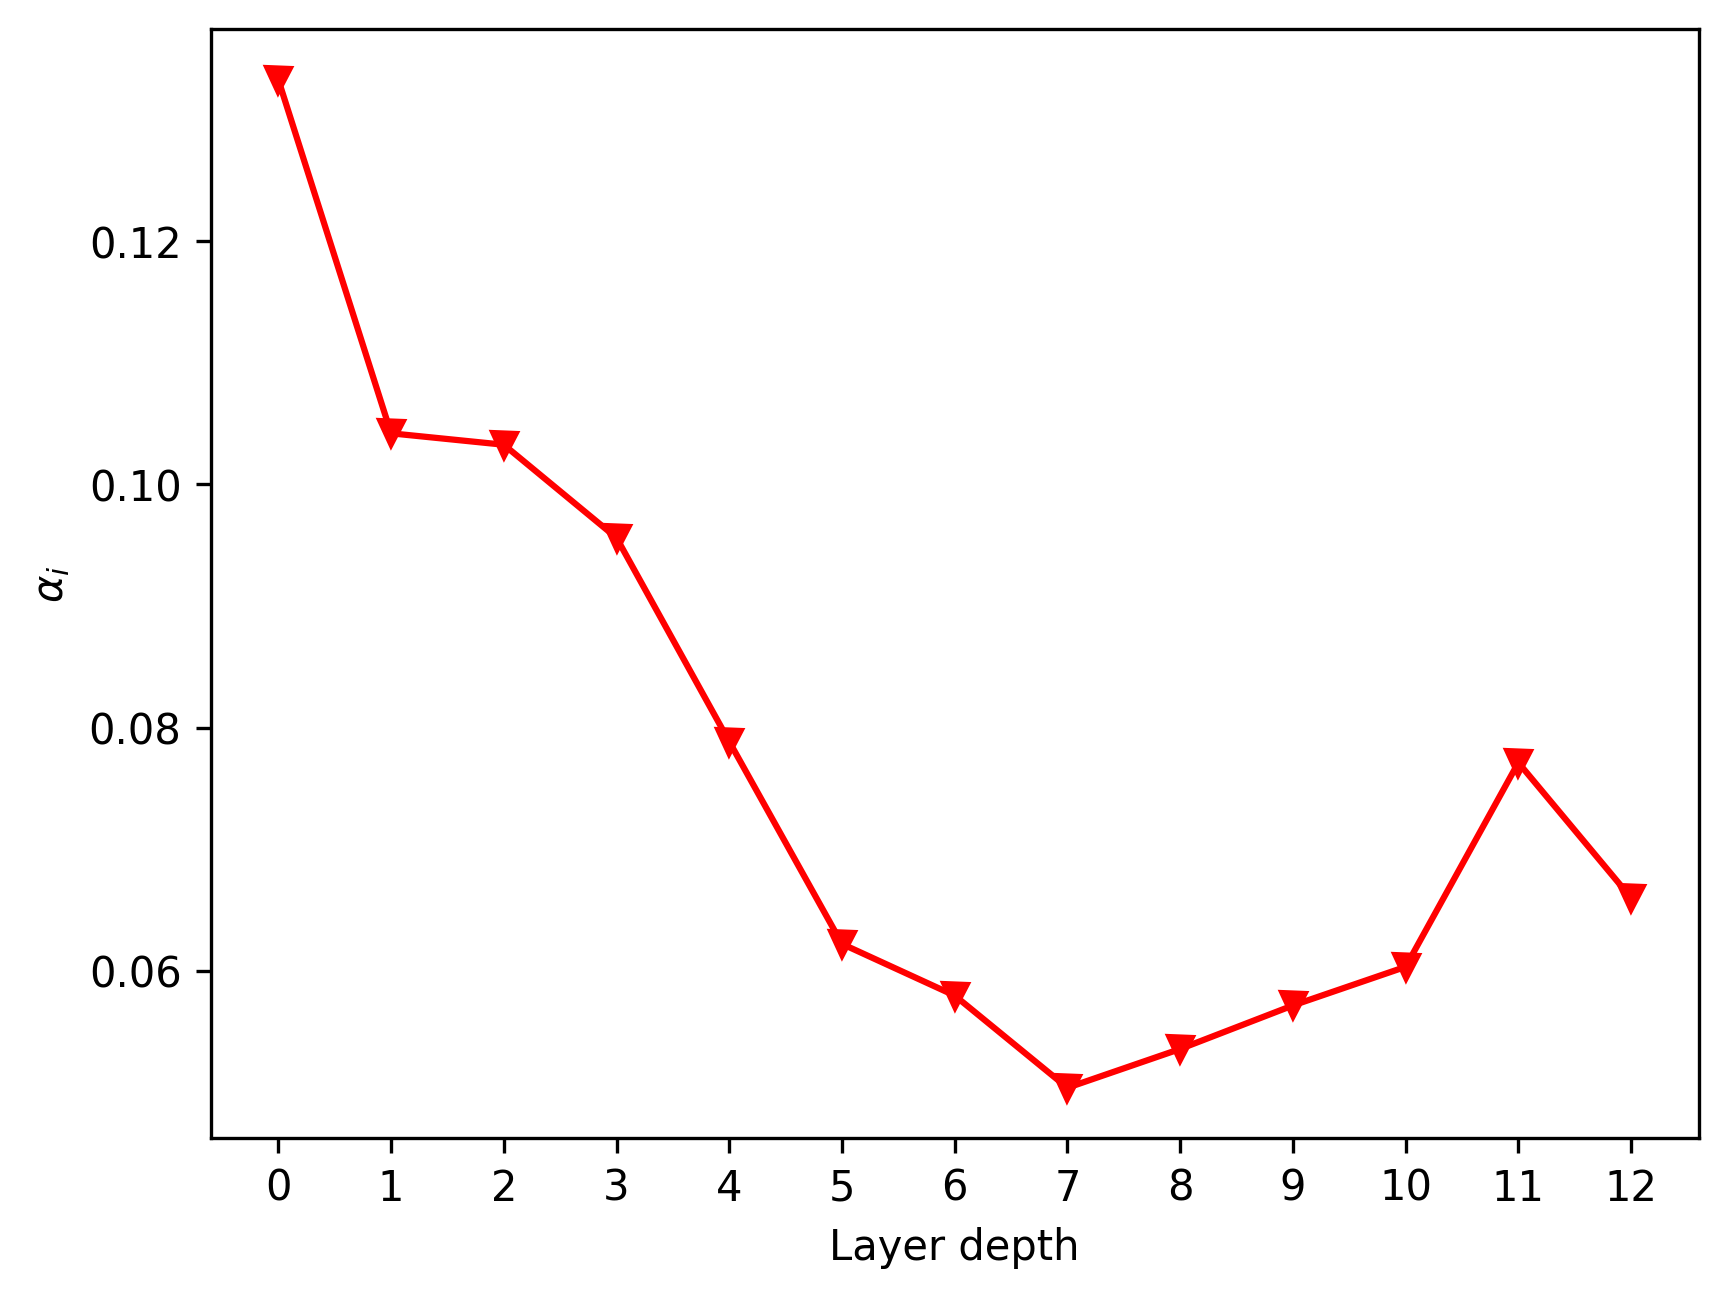

In [84]:
# plot the torch.nn.functional.softmax(dense_mos.weighted_average.weights, dim=0)
# aka the layer number and its importance
softmax_weights = torch.nn.functional.softmax(dense_mos.weighted_average.weights, dim=0).detach().cpu().numpy()
#save the weights to a csv
weights = pd.DataFrame({'softmax_weights': softmax_weights})
weights.to_csv('softmax_weights.csv', index=False)

plt.plot(softmax_weights, marker='v', linestyle='-', color='red', alpha=1, label='Softmax Weights')
plt.xlabel('Layer depth')
plt.xticks(range(13))
# y label is alpha character, the greek letter, with a subindice 
plt.ylabel(r'$\alpha_i$')
plt.show()

In [60]:
softmax_weights[0] = 0.066

# Evaluation and Testing

In [85]:
# Create the testing DataLoader
test_csv_path = "/home/aleph/tesis/classifier/test_shuffled.csv"
test_dataset = MOSDataset(test_csv_path, split='test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load the best model
best_model_path = "/home/aleph/tesis/classifier/DenseMOS_tests/best_model.pth"
dense_mos = DenseMOS(input_dim=768, hidden_dim=128, dropout_prob=0.6, num_layers=13)  # Ensure correct model initialization
dense_mos.to(device)  # Move the model to the device
dense_mos.load_state_dict(torch.load(best_model_path))  # Load the saved models
dense_mos.eval()  # Set model to evaluation mode

# Evaluate the model on the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # DataLoader for testing
test_loss = 0.0
outputs_list = []
targets_list = []
with torch.no_grad():  # No gradients needed during evaluation
    for inputs, targets in test_loader:
        inputs = inputs.to(device)  # Move inputs to the GPU
        targets = targets.to(device)  # Move targets to the GPU
        outputs = dense_mos(inputs)  # Forward pass
        outputs_list.append(outputs)
        targets_list.append(targets)
        loss = loss_fn(outputs, targets)  # Calculate loss
        test_loss += loss.item()  # Accumulate the loss

# Average test loss over all batches
avg_test_loss = test_loss / len(test_loader)
print("Test Loss:", avg_test_loss)  # Evaluate the model's performance on the test set

# Convert targets and outputs to NumPy arrays
targets = np.squeeze(torch.cat(targets_list).cpu().numpy())
outputs = np.squeeze(torch.cat(outputs_list).cpu().numpy())


Test Loss: 1.0933146935242872


In [87]:
# calculate pearson's correlation coefficient and targets_array, compute mae, mse, rmse and r2
# between the predicted MOS scores and the ground truth MOS scores, aka the targets and outputs

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

# Calculate Pearson's correlation coefficient
pearson_corr = pearsonr(targets, outputs)
print("Pearson's Correlation Coefficient:", pearson_corr[0])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(targets, outputs)
print("Mean Absolute Error (MAE):", mae)
rmse = mean_squared_error(targets, outputs, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)
r2 = r2_score(targets, outputs)
print("R^2 Score:", r2)


Pearson's Correlation Coefficient: 0.6165380026903736
Mean Absolute Error (MAE): 0.8018651
Root Mean Squared Error (RMSE): 1.056189
R^2 Score: 0.32150545003124
Mean Error: 0.118341796


/home/aleph/tesis/.env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [88]:
# print target and outputs side by side
# for i in range(200):
#     print(f"Target: {targets[i]:.2f}, Output: {outputs[i]:.2f}")
# print outputs that are above 5
for i in range(len(outputs)):
    if outputs[i] > 5:
        print(f"Target: {targets[i]:.2f}, Output: {outputs[i]:.2f}")
        # print stimuli name
        print(test_dataset.data.iloc[i]['stimuli'])

In [51]:
# combine targets and outputs into a dataframe
results = pd.read_csv("test_results.csv")
# clip values between 1 and 5
results['output'] = results['output'].clip(1, 5)
results
# results

,target,output
0,2.0,1.553135
1,2.0,2.007082
2,3.0,2.103801
3,1.0,1.196341
4,3.0,2.990961
...,...,...
387,1.0,1.000000
388,4.0,5.000000
389,3.0,1.689933
390,3.0,1.335288


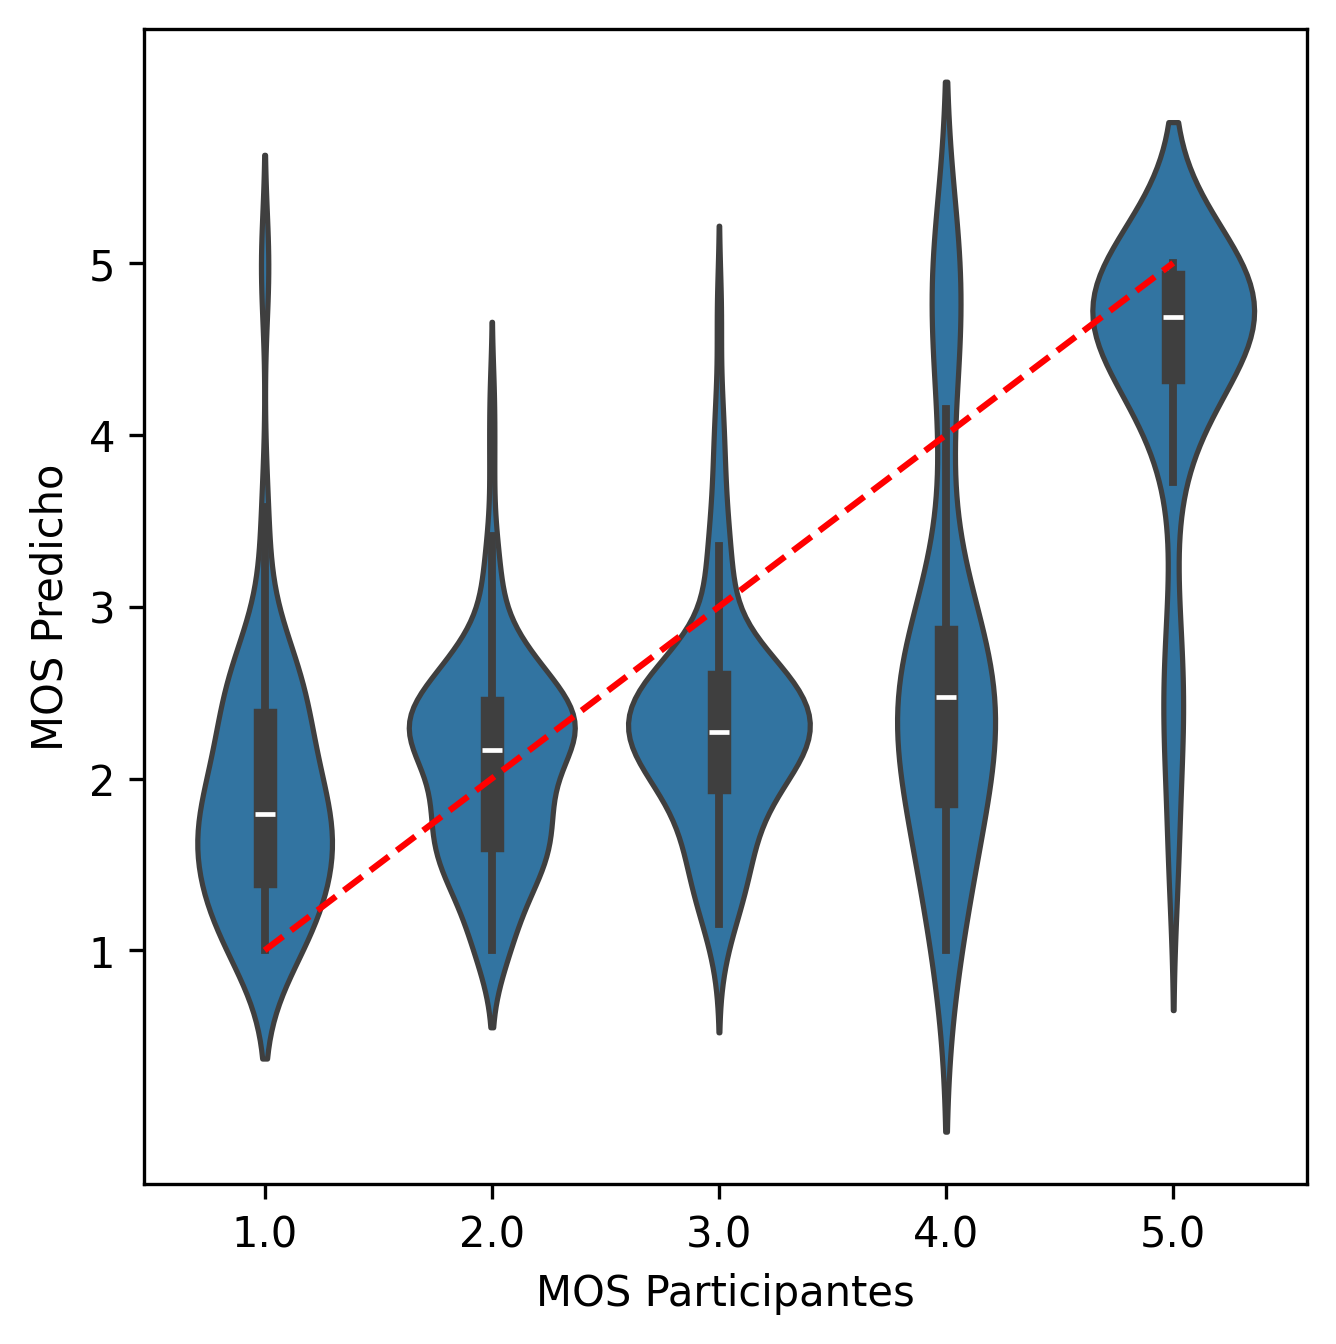

In [70]:
# violin plot of the targets and outputs
import seaborn as sns
import matplotlib.pyplot as plt


# now, lets plot the same data but with seaborn using a violin plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.violinplot(x=results["target"], y=results["output"])
# ax.set_title('Wav2vec2-PT')
ax.set_xlabel('MOS Participantes')
ax.set_ylabel('MOS Predicho')
ax.plot([0, 4], [1, 5], 'r--')
plt.yticks([1,2,3,4,5])
plt.show()
